<a href="https://colab.research.google.com/github/Navya003/NLP/blob/main/cvec_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.1 MB/s 
     |████████████████████████████████| 166 kB 51.9 MB/s 
     |████████████████████████████████| 182 kB 54.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 166 kB 47.8 MB/s 
     |████████████████████████████████| 162 kB 57.6 MB/s 
     |████████████████████████████████| 162 kB 54.2 MB/s 
     |████████████████████████████████| 158 kB 54.6 MB/s 
     |████████████████████████████████| 157 kB 54.6 MB/s 
     |████████████████████████████████| 157 kB 57.1 MB/s 
     |████████████████████████████████| 157 kB 69.4 MB/s 
     |████████████████████████████████| 157 kB 69.9 MB/s 
     |████████████████████████████████| 157 kB 60.7 MB/s 
     |████████████████████████████████| 157 kB 60.3 MB/s 
     |████████████████████████████████| 157 kB 73.7 MB/s 
     |████████████████████████████

In [ ]:
import numpy as np
import pandas as pd
import re
import wandb
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import category_encoders as ce
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, f1_score, precision_score, recall_score
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#functions
def encode_labels(DataFrame, col_name):
    df_ce=DataFrame.copy()
    encoder=ce.OrdinalEncoder(cols=[col_name])
    df = encoder.fit_transform(df_ce)
    return df

def clean_text(col_name):
    corpus = []
    for w in range(len(col_name)):
        desc = col_name[w].lower()
        #remove punctuation
        desc = re.sub('[^a-zA-Z]', ' ', desc)
        #remove tags
        desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
        #remove digits and special chars
        desc=re.sub("(\\d|\\W)+"," ",desc)
        corpus.append(desc)
    return corpus

def tf_idf(corpus, labels, max_features, n_gram_from=1, n_gram_to=1):
  #create count vectorizer and tf vectorizer models
  tf_vec = TfidfTransformer(smooth_idf=False)
  cvec = CountVectorizer(max_features=max_features, ngram_range=(n_gram_from, n_gram_to))
  #get the term frequencies: [n_samples, n_features].
  tf = cvec.fit_transform(corpus)
  #get IDF too.
  tfidf = tf_vec.fit_transform(tf)
  tfidf=tfidf.toarray()
  np.nan_to_num(tfidf)
  tf_labels=np.array(labels)
  feature=cvec.get_feature_names_out()
  return tfidf, tf_labels, feature

def split_dataset(X, Y, train_ratio, test_ratio, validation_ratio):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
    return x_train, y_train, x_test, y_test, x_val, y_val

def train_model(model, param, x_train, y_train, x_test):
   clf=model(param)
   # fit the training data into the model
   clf.fit(x_train, y_train)
   y_pred=clf.predict(x_test)
   y_probas=clf.predict_proba(x_test)
   return clf, y_pred, y_probas

def model_metrics(model, x_test, y_test, y_pred):
  # accuracy prediction
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  # classification report
  print("Classification report:\n")
  print(classification_report(y_test, y_pred))
  # confusion matrix
  conf=confusion_matrix(y_test, y_pred)
  print("Confusion matrix:\n", conf)

def grid_search(model, param, scoring):
    clf_grid=GridSearchCV(estimator=model, param_grid=param, scoring = scoring , refit = 'recall' , cv = 3, verbose=2, n_jobs = 4)
    # fit the training data
    clf_grid.fit(x_train,y_train)
    # Best hyperparameter values
    print('Best parameter values:')
    print(clf_grid.best_params_)
    # predicted values from the grid search model
    clf_g=clf_grid.best_estimator_
    y_pred=clf_g.predict(x_test)
    y_probas = clf_g.predict_proba(x_test)
    return clf_g, y_pred, y_probas

def random_search(model, param, scoring):
    clf_ran=RandomizedSearchCV(estimator=model, param_distributions = param, scoring = scoring, refit = 'recall', cv = 3, verbose=2, n_jobs = 4)
    # fit the training data
    clf_ran.fit(x_train,y_train)
    # Best hyperparameter values
    print('Best parameter values:')
    print(clf_ran.best_params_)
    # predicted values from the random search model
    clf_r=clf_ran.best_estimator_
    y_pred=clf_r.predict(x_test)
    y_probas = clf_r.predict_proba(x_test)
    return clf_r, y_pred, y_probas

def bay_opt(model, param, scoring):
  # we need to define space from param grid
  # we are using choice-categorical variable distribution type to define space
  def space_(param):
    space = {key : hp.choice(key, param[key]) for key in param}
    return space

  #given below is an example of how space corresponds to param
  #param = {"learning_rate": [0.0001,0.001, 0.01, 0.1, 1] , "max_depth": range(3,21,3), "gamma": [i/10.0 for i in range(0,5)],"colsample_bytree": [i/10.0 for i in range(3,10)],"reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],"reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
  #space = {'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),'max_depth' : hp.choice('max_depth', range(3,21,3)),'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])}

  # Set up the k-fold cross-validation
  kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

  # Objective function
  # detach cross validation from sweep
  def objective(params):
    estimator = model(**params)
    scores = cross_val_score(estimator, x_train, y_train, cv=kfold, scoring = scoring, n_jobs=-1)
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
  # Trials to track progress
  bayes_trials = Trials()
  # Optimize
  best = fmin(fn = objective, space = space_(param), algo = tpe.suggest, max_evals = 48, trials = bayes_trials)
  # the index of the best parameters (best)
  # the values of the best parameters
  param_b = space_eval(space_(param), best)

  clf_bo = model(**param_b).fit(x_train, y_train)
  y_pred=clf_bo.predict(x_test)
  y_probas = clf_bo.predict_proba(x_test)
  return clf_bo, y_pred, y_probas

def feature_imp(model,feature_names, n_top_features):
  #wandb.init(project='test RF-eng')
  feats=np.array(feature_names)
  importances = model.feature_importances_
  indices = np.argsort(importances)[::-1]
  #for f in range(50):
    #print("%d. feature %d - %s : %f" % (f+1, indices[f], feats[f], importances[indices[f]]))
  plt.figure(figsize=(8,10))
  plt.barh(feats[indices][:n_top_features ], importances[indices][:n_top_features ])
  plt.xlabel("RF feature Importance ")
  #wandb.log({"plot": plt})

def token_freq_plot(feature, X):
  #wandb.init(project='test RF-eng')
  visualizer = FreqDistVisualizer(features=feature, orient='v')
  visualizer.fit(X)
  #visualizer.to_json()
  #wandb.log({"plot": visualizer})
  visualizer.show()


def best_sweep(entity, project):
  api = wandb.Api()

  runs = api.runs(entity + "/" + project)

  # download metrics from all runs
  print("Get metrics from all runs")

  summary_list, config_list, name_list = [], [], []
  for run in runs:
      # .summary contains the output keys/values for metrics like accuracy.
      summary_list.append(run.summary._json_dict)
      # .config contains the hyperparameters.
      #  We remove special values that start with _.
      config_list.append(
          {k: v for k,v in run.config.items()
           if not k.startswith('_')})
      # .name is the human-readable name of the run.
      name_list.append(run.name)

  runs_df = pd.DataFrame({
      "summary": summary_list,
      "config": config_list,
      "name": name_list
      })

  runs_df.to_csv('metrics.csv')
  # identify best model file from the sweep
  metric_opt='f1'
  runs = sorted(runs, key=lambda run: run.summary.get(metric_opt, 0), reverse=True)
  score = runs[0].summary.get(metric_opt, 0)
  print(f"Best sweep {runs[0].name} with {metric_opt}={score}%")


In [ ]:
df_en = pd.read_csv('fake_or_real_news.csv')
df_en.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df=encode_labels(df_en, 'label')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,2
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,2


In [ ]:
df.title[15]

'How women lead differently'

In [ ]:
# Cleaning the text of punctuation and special characters
corpus=clean_text(df.title)
corpus[15]

'how women lead differently'

###Countvectorizer


In [ ]:
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(corpus).toarray()
# resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
#cv.vocabulary_
Y=np.array(df['label'])
# X and Y should have same length
print(X.shape)
print(Y.shape)

(6335, 1000)
(6335,)


In [ ]:
def token_freq_plot(feature, X):
  wandb.init(project='test RF-eng')
  visualizer = FreqDistVisualizer(features=feature, orient='v')
  visualizer.fit(X)
  #visualizer.to_json()
  wandb.log({"plot": visualizer})
  visualizer.show()
feature=cv.get_feature_names_out()
print
token_freq_plot(feature, X)

In [ ]:
feature=cv.get_feature_names_out()
feat=pd.DataFrame(feature)
freq=feat.value_counts().nlargest(30)
freq

abedin          1
potential       1
points          1
polarization    1
police          1
policy          1
political       1
politics        1
poll            1
polling         1
polls           1
poor            1
pope            1
possible        1
post            1
power           1
problem         1
powerful        1
prepare         1
presidency      1
president       1
presidential    1
press           1
pressure        1
prevent         1
primaries       1
primary         1
prison          1
private         1
pro             1
dtype: int64

In [ ]:
# the logging should be done as part of an existing job
# if not, init an existing job
wandb.init(project='test RF-eng', name='Token frequency distribution"')
feature=cv.get_feature_names_out()
feat=pd.DataFrame(feature)
freq=feat.value_counts().nlargest(30)
freq = pd.DataFrame(freq)#.reset_index()
freq.columns = ["token", "frequency"]
freq = wandb.Table(data=freq, columns=["token", "frequency"])
wandb.log({"Token frequency distribution": wandb.plot.bar(freq, "token", "frequency" , title="Token frequency distribution")})
wandb.finish()

ValueError: ignored

In [ ]:
# split the dataset into train, test and validation set using sklearn
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15
# train is now 70% of the entire data set
# test is now 15% of the initial data set
# validation is now 15% of the initial data set
x_train, y_train, x_test, y_test, x_val, y_val=split_dataset(X, Y, train_ratio, test_ratio, validation_ratio)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(4434, 1000)
(4434,)
(951, 1000)
(951,)
(950, 1000)
(950,)


In [ ]:
print('RF BASE MODEL')
wandb.init(project='test RF')
# training the model
model=RandomForestClassifier
param=100
max_features=1000
rf_base, y_pred, y_probas=train_model(model, param, x_train, y_train)
wandb.log({'accuracy': accuracy_score(y_test, y_pred), 'cvec_features':max_features})
# model metrics
model_metrics(rf_base, x_test, y_test, y_pred)
# SHAP Plot
#shap_plot(rf_base, x_test)

RF BASE MODEL


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Accuracy: 78.65%
Classification report:

              precision    recall  f1-score   support

           1       0.78      0.81      0.80       489
           2       0.79      0.77      0.78       462

    accuracy                           0.79       951
   macro avg       0.79      0.79      0.79       951
weighted avg       0.79      0.79      0.79       951

Confusion matrix:
 [[394  95]
 [108 354]]


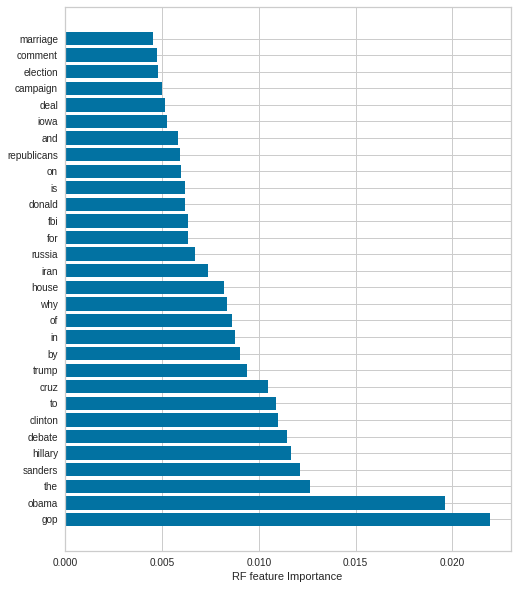

In [ ]:
# feature importance plot
feature_imp(rf_base,feature, 30)

In [ ]:
# wandb plot
wandb.init(project="test RF-eng", name="RF-base model")
# Visualize all classifier plots at once
wandb.sklearn.plot_classifier(rf_base, x_train, x_test, y_train, y_test, y_pred, y_probas, labels=None, model_name='BASE MODEL', feature_names=feature)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: 
wandb: Plotting BASE MODEL.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# parameters currently used
print('Parameters currently in use:')
pprint(rf_base.get_params())

Parameters currently in use:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Setting range of parameters
# Number of trees in random forest
#n_estimators = [1000, 2000, 3000]
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 2, 3]
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
scoring = ['recall']
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print('Range of parameters used for hyperparameter tuning:')
pprint(param)

Range of parameters used for hyperparameter tuning:
{'bootstrap': [True, False],
 'max_depth': [1, 2, 3],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 3],
 'n_estimators': [100]}


In [ ]:
# Hyperparameter tuning using GridsearchCV
print("\nGRID SEARCH MODEL")
# Grid Search model
rf_grid, y_pred1, y_probas1=grid_search(rf_base, param, scoring)
# model metrics
model_metrics(rf_grid, x_test, y_test, y_pred1)
# SHAP Plot
#shap_plot(rf_grid, x_test)


GRID SEARCH MODEL
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameter values:
{'bootstrap': False, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}
Accuracy: 65.30%
Classification report:

              precision    recall  f1-score   support

           1       0.79      0.46      0.58       500
           2       0.59      0.87      0.70       451

    accuracy                           0.65       951
   macro avg       0.69      0.66      0.64       951
weighted avg       0.70      0.65      0.64       951

Confusion matrix:
 [[230 270]
 [ 60 391]]


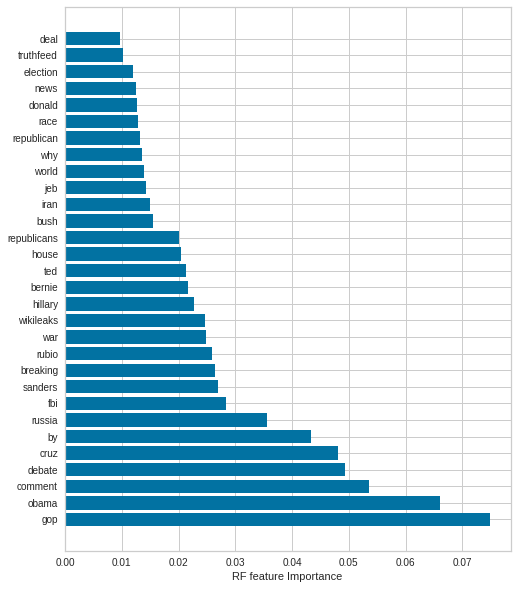

In [ ]:
# feature importance plot
feature_imp(rf_grid,feature, 30)

In [ ]:
# wandb plot
wandb.init(project="test RF-eng", name="RF-Grid Search model")
# Visualize all classifier plots at once
wandb.sklearn.plot_classifier(rf_grid, x_train, x_test, y_train, y_test, y_pred1, y_probas1, labels=None, model_name='Grid Search Model', feature_names=None)


wandb: 
wandb: Plotting Grid Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
print("\nRANDOM SEARCH MODEL")
#print('Range of parameters used for hyperparameter tuning:')
#pprint(param)
# Random search model
rf_ran, y_pred2, y_probas2=random_search(rf_base, param, scoring)
# model metrics
model_metrics(rf_ran, x_test, y_test, y_pred2)
# SHAP Plot
#shap_plot(rf_ran, x_test)


RANDOM SEARCH MODEL
Range of parameters used for hyperparameter tuning:
{'bootstrap': [True, False],
 'max_depth': [1, 2, 3],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 3],
 'n_estimators': [100]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameter values:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 2, 'bootstrap': True}
Accuracy: 60.04%
Classification report:

              precision    recall  f1-score   support

           1       0.84      0.30      0.44       500
           2       0.55      0.94      0.69       451

    accuracy                           0.60       951
   macro avg       0.69      0.62      0.56       951
weighted avg       0.70      0.60      0.56       951

Confusion matrix:
 [[148 352]
 [ 28 423]]


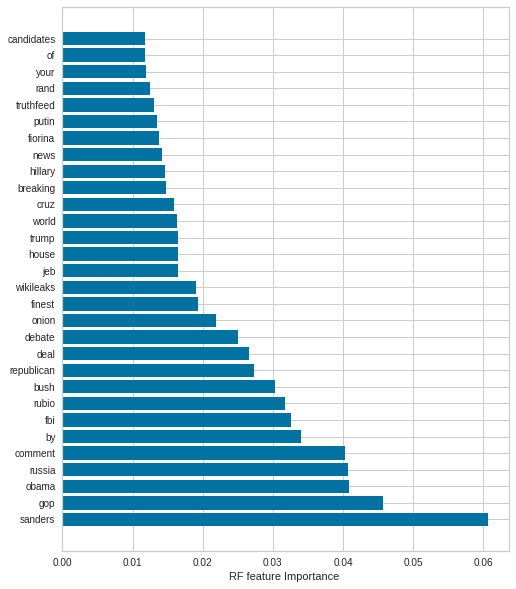

In [ ]:
# feature importance plot
feature_imp(rf_ran,feature, 30)

In [ ]:
# wandb plot
# Visualize all classifier plots at once
wandb.init(project="test RF-eng", name="RF-Random Search model")
wandb.sklearn.plot_classifier(rf_ran, x_train, x_test, y_train, y_test, y_pred2, y_probas2, labels=None, model_name='Random Search Model', feature_names=None)


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.



BAYESIAN OPTIMISATION MODEL
100%|██████████| 48/48 [00:53<00:00,  1.12s/it, best loss: -0.9460188933873145]
Accuracy: 65.93%
Classification report:

              precision    recall  f1-score   support

           1       0.60      0.93      0.73       473
           2       0.85      0.39      0.54       478

    accuracy                           0.66       951
   macro avg       0.72      0.66      0.63       951
weighted avg       0.73      0.66      0.63       951

Confusion matrix:
 [[439  34]
 [290 188]]
Feature Importance Plot:



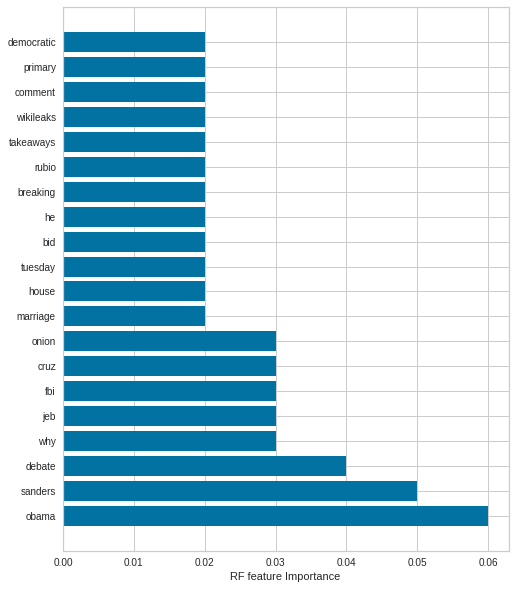

In [ ]:
# Bayesian optimization
print('\nBAYESIAN OPTIMISATION MODEL')
scoring_rf='recall'
rf_bayes, y_pred3, y_probas3 = bay_opt(RandomForestClassifier, param, scoring_rf)
# model metrics
model_metrics(rf_bayes, x_test, y_test, y_pred3)
print("Feature Importance Plot:\n")
feature_imp(rf_bayes, feature, 20)

In [ ]:
# wandb plot
# Visualize all classifier plots at once
wandb.init(project="test RF-eng", name="RF-Bayesian opt. model")
wandb.sklearn.plot_classifier(rf_bayes, x_train, x_test, y_train, y_test, y_pred3, y_probas3, labels=None, model_name='Random Search Model', feature_names=feature)
wandb.finish()

wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
#wandb sweeps
def RFsweep():
    wandb.init(settings=wandb.Settings(console='off', start_method='fork'))
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    pred_prob = clf.predict_proba(x_test)
    feature=cv.get_feature_names_out()
    #print(classification_report(y_test, preds))
    # Log any metric with Weights and Biases
    wandb.log({'accuracy_score': accuracy_score(y_test,preds),
               'f1':f1_score(y_test,preds),
               'precision': precision_score(y_test, preds),
               'recall': recall_score(y_test, preds)})
    wandb.sklearn.plot_classifier(clf, x_train, x_test, y_train, y_test,
                                  preds, pred_prob, labels=None, model_name='Random Search Model', feature_names=feature)

In [ ]:
sweep_config = {
        'name'  : "random",
        'method': 'random', #grid, random
        'metric': {
          'name': 'f1_score',
          'goal': 'maximize' },
        'parameters': {
          "n_estimators" : {
          "values" : [100, 200]},
          "max_depth" :{
          "values": [10, 20, 30]},
          "min_samples_leaf":{
          "values":[1, 2, 3, 4, 5]},
          "min_samples_split":{
          "values":[1, 2, 3, 4, 5]}, }}

sweep_id = wandb.sweep(sweep_config, project='test sweep-eng')
count=3
wandb.agent(sweep_id,function=RFsweep, count=count)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: gvnnmevv
Sweep URL: https://wandb.ai/tyagilab/test%20sweep-eng/sweeps/gvnnmevv


wandb: Agent Starting Run: n0zz0xsc with config:
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 200
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: navya-tyagi (tyagilab). Use `wandb login --relogin` to force relogin


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.78233
f1,0.78505
precision,0.80769
recall,0.76364


wandb: Agent Starting Run: ndbkc6y6 with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.77918
f1,0.78079
precision,0.80778
recall,0.75556


wandb: Agent Starting Run: jkoaw2vh with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.78233
f1,0.78505
precision,0.80769
recall,0.76364


In [ ]:
sweep_config1 = {
        'name'  : "grid",
        'method': 'grid', #grid, random
        'metric': {
          'name': 'f1_score',
          'goal': 'maximize' },
        'parameters': {
          "n_estimators" : {
          "values" : [100, 200]},
          "max_depth" :{
          "values": [10, 20, 30]},
          "min_samples_leaf":{
          "values":[1, 2, 3, 4, 5]},
          "min_samples_split":{
          "values":[1, 2, 3, 4, 5]}, }}

sweep_id1 = wandb.sweep(sweep_config1, project='test sweep-eng')
count=3
wandb.agent(sweep_id1,function=RFsweep, count=count)
wandb.finish()

Create sweep with ID: 9skjg18v
Sweep URL: https://wandb.ai/tyagilab/test%20sweep-eng/sweeps/9skjg18v


wandb: Agent Starting Run: 856nujfu with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 1
wandb: 	n_estimators: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.78759
f1,0.79303
precision,0.80457
recall,0.78182


wandb: Agent Starting Run: 2mnazy69 with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 1
wandb: 	n_estimators: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.7897
f1,0.79296
precision,0.81316
recall,0.77374


wandb: Agent Starting Run: 9hgqf24q with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.78128
f1,0.78468
precision,0.80467
recall,0.76566


In [ ]:
sweep_config2 = {
        'name'  : "bayesian",
        'method': 'bayes', #grid, random
        'metric': {
          'name': 'f1_score',#f1 score
          'goal': 'maximize' },
        'parameters': {
          "n_estimators" : {
          "values" : [100, 200]},
          "max_depth" :{
          "values": [10, 20, 30, 40, 50]},
          "min_samples_leaf":{
          "values":[1, 2, 3, 4, 5]},
          "min_samples_split":{
          "values":[1, 2, 3, 4, 5]}, }}

sweep_id2 = wandb.sweep(sweep_config2, project='test sweep-eng')
count=3
wandb.agent(sweep_id2,function=RFsweep, count=count)
wandb.finish()

Create sweep with ID: 27tfbm52
Sweep URL: https://wandb.ai/tyagilab/test%20sweep-eng/sweeps/27tfbm52


wandb: Agent Starting Run: 8jqrdvhs with config:
wandb: 	max_depth: 30
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.78654
f1,0.79007
precision,0.80932
recall,0.77172


wandb: Agent Starting Run: gw5mprzv with config:
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.77918
f1,0.78079
precision,0.80778
recall,0.75556


wandb: Agent Starting Run: pwhkhyuc with config:
wandb: 	max_depth: 50
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: 
wandb: Plotting Random Search Model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy_score,▁
f1,▁
precision,▁
recall,▁
accuracy_score,0.77918
f1,0.77941
precision,0.81182
recall,0.74949


In [ ]:
# Exporting metrics from a project in to a CSV file
# set to your entity and project
# best model
best_sweep('tyagilab', 'test sweep-eng')

Get metrics from all runs
Best fold classic-sweep-1 with f1=0.7930327868852459%


### Tf-idf and cvec

Total data items: (6335, 1000)
Total data labels (6335,)


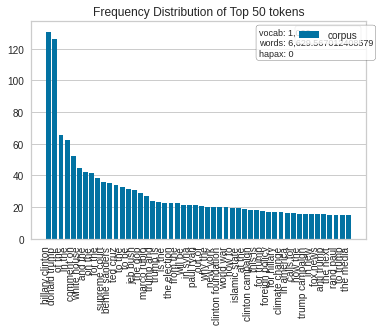

In [ ]:
max_features=1000
n_gram_from=2
n_gram_to=2
tfidf, tf_labels, feature=tf_idf(corpus, df.label, max_features, n_gram_from, n_gram_to)
print("Total data items:",tfidf.shape)
print("Total data labels",tf_labels.shape)
token_freq_plot(feature, tfidf)

In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

x_train, y_train, x_test, y_test, x_val, y_val=split_dataset(tfidf, tf_labels, train_ratio, test_ratio, validation_ratio)
print("Training data:",x_train.shape)
print("Training data labels:",y_train.shape)
print("Test data:",x_test.shape)
print("Test data labels:",y_test.shape)
print("Validation data:",x_val.shape)
print("Validation data labels:",y_val.shape)

Training data: (4434, 1000)
Training data labels: (4434,)
Test data: (951, 1000)
Test data labels: (951,)
Validation data: (950, 1000)
Validation data labels: (950,)


RF BASE MODEL
Accuracy: 68.66%
Classification report:

              precision    recall  f1-score   support

           1       0.66      0.81      0.72       484
           2       0.74      0.56      0.64       467

    accuracy                           0.69       951
   macro avg       0.70      0.68      0.68       951
weighted avg       0.70      0.69      0.68       951

Confusion matrix:
 [[390  94]
 [204 263]]
Feature Importance Plot:



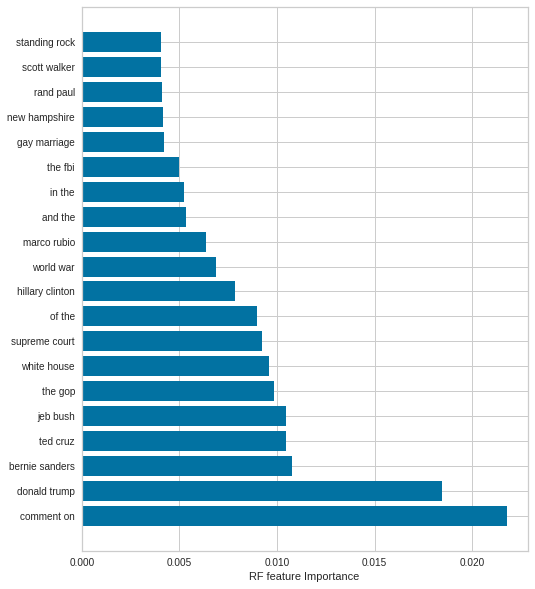

In [ ]:
print('RF BASE MODEL')
# training the model
model=RandomForestClassifier
param=100
rf_base, y_pred, y_probas=train_model(model, param, x_train, y_train, x_test)
# model metrics
model_metrics(rf_base, x_test, y_test, y_pred)
print("Feature Importance Plot:\n")
feature_imp(rf_base, feature, 20)

In [ ]:
# feature importance plot
feature_imp(clf_b,feature, 30)

In [ ]:
# parameters cuurently used
print('Parameters currently in use:')
pprint(clf_b.get_params())

In [ ]:
# Setting range of parameters
# Number of trees in random forest
#n_estimators = [1000, 2000, 3000]
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 2, 3]
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print('Range of parameters used for hyperparameter tuning:')
pprint(param)

Range of parameters used for hyperparameter tuning:


NameError: ignored

In [ ]:
# Hyperparameter tuning using GridsearchCV
print("\nGRID SEARCH MODEL")
# Grid Search model
clf_grid, l_pred1, l_probas1=grid_search(clf_b, param)
# model metrics
model_metrics(clf_grid, tf_test, l_test, l_pred1)
# SHAP Plot
#shap_plot(rf_grid, x_test)
# wandb plot
# Visualize all classifier plots at once
#wandb.sklearn.plot_classifier(rf_grid, x_train, x_test, y_train, y_test, y_pred1, y_probas1, labels=None, model_name='Grid Search Model', feature_names=None)
#Feature imp plot
#feature_imp(rf_grid, df.index, 50)

In [ ]:
# feature importance plot
feature_imp(clf_grid,feature, 30)

In [ ]:
print("\nRANDOM SEARCH MODEL")
print('Range of parameters used for hyperparameter tuning:')
pprint(param)
# Random search model
clf_ran, l_pred2, l_probas2=random_search(clf_b, param)
# model metrics
model_metrics(clf_ran, tf_test, l_test, l_pred2)
# SHAP Plot
#shap_plot(rf_ran, x_test)
# wandb plot
# Visualize all classifier plots at once
#wandb.sklearn.plot_classifier(rf_ran, x_train, x_test, y_train, y_test, y_pred2, y_probas2, labels=None, model_name='Random Search Model', feature_names=None)
#Feature imp plot
#feature_imp(rf_ran, df.index, 50)

In [ ]:
# feature importance plot
feature_imp(clf_ran,feature, 30)